# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations

sys.path.append("../src/")

import xgi
from reducibility_hg import *

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir = f"{results_dir}synthetic/"

In [3]:
def plot_3panels(info_losses, complexities, orders, labels, legend_title=None):

    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(7, 2.1), constrained_layout=True, sharey=True
    )

    n = len(info_losses)

    for i in range(n):
        ax1.plot(orders[i], info_losses[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax1.set_title("Information Loss (KL)")
    ax1.set_xlabel("Max Order")
    ax1.set_ylabel("Bits")

    for i in range(n):
        ax2.plot(orders[i], complexities[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax2.set_title("Model Complexity ($\delta S$)")
    ax2.set_xlabel("Max Order")

    for i in range(n):
        message_length = complexities[i] + info_losses[i]
        ax3.plot(orders[i], message_length, "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax3.legend(
        title=legend_title, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left"
    )

    ax3.set_title("Message Length")
    ax3.set_xlabel("Max Order")

    sb.despine()

    # fig.suptitle(f"Complete hypergraph N={N}")

    # fig_name = f"message_length_complete_hypergraph_N{N}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

    # plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

    return fig, (ax1, ax2, ax3)

# Random Simplicial Complex up to order 4

In [4]:
N = 100
ps = 5 * np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])

H0 = xgi.random_simplicial_complex(N, ps=ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [5]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=False)
tau_c
# 0.01837792426533645

0.01837792426533645

In [6]:
Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0, 0.9, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


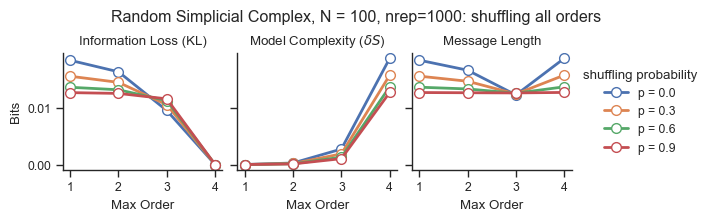

In [36]:
plot_3panels(
    np.mean(Ds_H, axis=0),
    np.mean(lZs_H, axis=0),
    [orders, orders, orders, orders],
    ["p = 0.0", "p = 0.3", "p = 0.6", "p = 0.9"],
    legend_title="shuffling probability",
)
plt.suptitle("Random Simplicial Complex, N = 100, nrep=1000: shuffling all orders")

fig_name = f"message_length_random_simplicial_complex_N_100_p_0_03_06_09"

# plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [12]:
Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [24]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()
df

0
0.25 0   [0.01709237045141343, 0.014594244590120764, 0....
     1   [0.013890573566872195, 0.012530159952431476, 0...
     2   [0.014752382792436868, 0.012676202070582163, 0...
     3   [0.016875125379403257, 0.014827957379808035, 0...
     4   [0.015746993690676097, 0.013951665071330926, 0...
...                                                    ...
1.00 95  [0.00993103353393521, 0.009780304277305966, 0....
     96  [0.010016766723090965, 0.010177610305495487, 0...
     97  [0.010681516272985792, 0.01059116030704986, 0....
     98  [0.00938848077242245, 0.009330465860151939, 0....
     99  [0.010279447229921707, 0.010227066633951922, 0...

[400 rows x 1 columns]

In [25]:
for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]
df

1         2         3         4
0.25 0   0.017092  0.014594  0.010533  0.017655
     1   0.013891  0.012530  0.011214  0.014284
     2   0.014752  0.012676  0.011400  0.015137
     3   0.016875  0.014828  0.011042  0.017348
     4   0.015747  0.013952  0.011836  0.016138
...           ...       ...       ...       ...
1.00 95  0.009931  0.009780  0.009484  0.009909
     96  0.010017  0.010178  0.009513  0.009941
     97  0.010682  0.010591  0.010604  0.010650
     98  0.009388  0.009330  0.008831  0.009398
     99  0.010279  0.010227  0.010595  0.010371

[400 rows x 4 columns]

In [26]:
dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.295e-09 t=-6.418e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:4.487e-01 t=-7.591e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:7.281e-01 t=3.482e-01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:4.020e-40 t=-1.863e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:5.377e-02 t=1.940e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.822e-66 t=-3.493e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:3.800e-24 t=1.172e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:7.207e-50 t=2.315e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.196e-10 t=6.820e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:2.399e-22 t=1.130

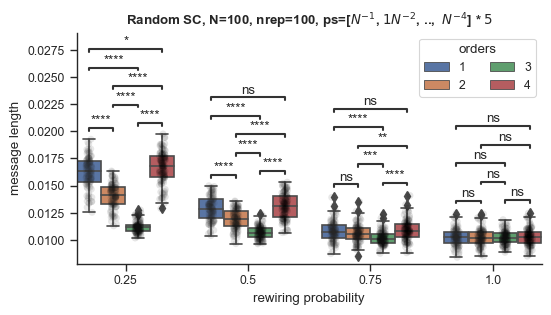

In [27]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(6, 3))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=2)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $5$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [29]:
N = 100
ps = 50 * np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])

H0 = xgi.random_simplicial_complex(N, ps=ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [30]:
Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [31]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()
df

0
0.25 0   [0.0031306309990186965, 0.0028234870030856146,...
     1   [0.0028023914383389914, 0.0025489058447923235,...
     2   [0.0027447689080975085, 0.0024674308458653565,...
     3   [0.002958110886214664, 0.0026319985984693955, ...
     4   [0.002868020846075084, 0.0025548501902017337, ...
...                                                    ...
1.00 95  [0.001653003894985447, 0.0016295295965023382, ...
     96  [0.002122672884214083, 0.002088260354128152, 0...
     97  [0.002282002929221115, 0.0022839292973274583, ...
     98  [0.0021551507463173844, 0.0021058055967966907,...
     99  [0.0022850265558370525, 0.0022659583146723977,...

[400 rows x 1 columns]

In [32]:
for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]
df

1         2         3         4
0.25 0   0.003131  0.002823  0.002211  0.003171
     1   0.002802  0.002549  0.001977  0.002846
     2   0.002745  0.002467  0.001917  0.002799
     3   0.002958  0.002632  0.002034  0.003011
     4   0.002868  0.002555  0.002103  0.002933
...           ...       ...       ...       ...
1.00 95  0.001653  0.001630  0.001599  0.001689
     96  0.002123  0.002088  0.001985  0.002185
     97  0.002282  0.002284  0.002218  0.002314
     98  0.002155  0.002106  0.002187  0.002176
     99  0.002285  0.002266  0.002251  0.002313

[400 rows x 4 columns]

In [33]:
dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.053e-08 t=-5.980e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:1.969e-04 t=-3.794e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:9.207e-02 t=1.693e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.731e-29 t=-1.339e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.708e-02 t=2.227e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.813e-78 t=-3.292e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:2.194e-19 t=1.003e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.751e-52 t=2.139e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:2.492e-05 t=4.318e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:8.880e-13 t=7.664

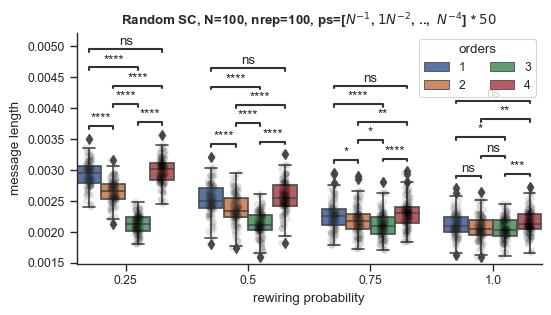

In [36]:
fix, ax = plt.subplots(figsize=(6, 3))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=2)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $50$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [14]:
N = 100
ps = 100 * np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])

H0 = xgi.random_simplicial_complex(N, ps=ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [15]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=False)
tau_c = 0.01837792426533645
tau_c
# 0.01837792426533645

0.01837792426533645

In [16]:
Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [17]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()
df

0
0.25 0   [0.002176383714060294, 0.00198071424707303, 0....
     1   [0.0019526008126417582, 0.0017547133846013419,...
     2   [0.0019335247530357091, 0.0017370908036933655,...
     3   [0.0021343482047072523, 0.0019263877797428483,...
     4   [0.001957091881736907, 0.0017806582937519924, ...
...                                                    ...
1.00 95  [0.0011231197759459868, 0.0010786511663631315,...
     96  [0.0011782663579067432, 0.0011292323296239956,...
     97  [0.001295612461980726, 0.0012658430963825643, ...
     98  [0.0012223839387873123, 0.001171280047698696, ...
     99  [0.0011989791267891167, 0.0011696754535978487,...

[400 rows x 1 columns]

In [18]:
for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]
df

1         2         3         4
0.25 0   0.002176  0.001981  0.001498  0.002215
     1   0.001953  0.001755  0.001312  0.001977
     2   0.001934  0.001737  0.001309  0.001960
     3   0.002134  0.001926  0.001506  0.002158
     4   0.001957  0.001781  0.001422  0.001985
...           ...       ...       ...       ...
1.00 95  0.001123  0.001079  0.001102  0.001157
     96  0.001178  0.001129  0.001177  0.001211
     97  0.001296  0.001266  0.001274  0.001326
     98  0.001222  0.001171  0.001121  0.001247
     99  0.001199  0.001170  0.001111  0.001233

[400 rows x 4 columns]

In [19]:
dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:9.580e-15 t=-8.405e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:4.910e-07 t=-5.203e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.332e-02 t=2.497e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.179e-37 t=-1.628e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.003e-03 t=3.131e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:2.360e-84 t=-3.615e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:3.485e-18 t=9.614e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:7.760e-61 t=2.478e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.676e-06 t=4.764e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:1.066e-18 t=9.828

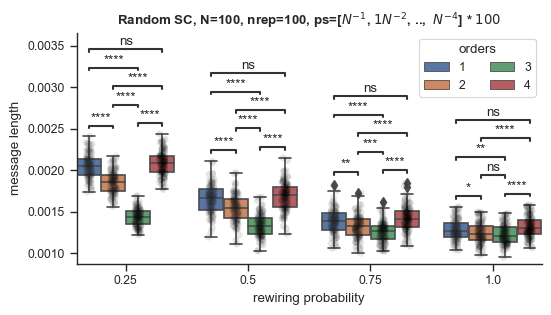

In [22]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(6, 3))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=2)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $100$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

## Varying $\tau$

In [5]:
N = 100
ps = 5 * np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])

H0 = xgi.random_simplicial_complex(N, ps=ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [19]:
tau_c = 0.02

Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [20]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.140e-11 t=-7.281e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:8.330e-01 t=-2.111e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:7.846e-01 t=2.737e-01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:9.173e-37 t=-1.611e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:8.066e-02 t=1.756e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:2.633e-76 t=-3.215e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:3.358e-19 t=1.001e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:5.294e-57 t=2.278e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:5.281e-07 t=5.194e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:4.609e-23 t=1.127

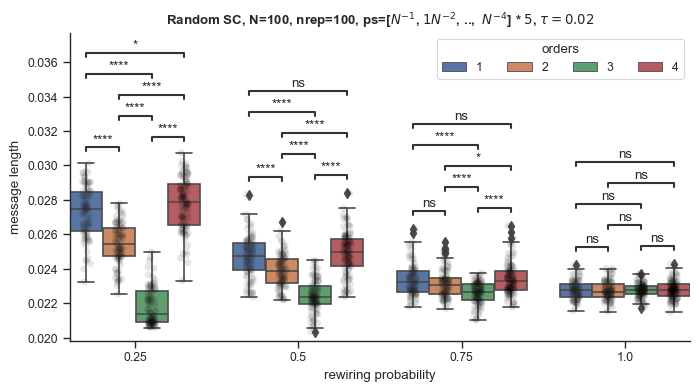

In [22]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $5$, $\tau=0.02$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_tau_002_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [23]:
tau_c = 0.1

Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [24]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.085e-04 t=-3.983e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:7.343e-01 t=-3.400e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.677e-01 t=1.385e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:2.216e-12 t=-7.776e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:8.872e-05 t=4.003e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.398e-30 t=-1.474e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:2.374e-47 t=1.945e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:3.136e-02 t=-2.173e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:7.288e-22 t=1.091e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:6.570e-01 t=-4.4

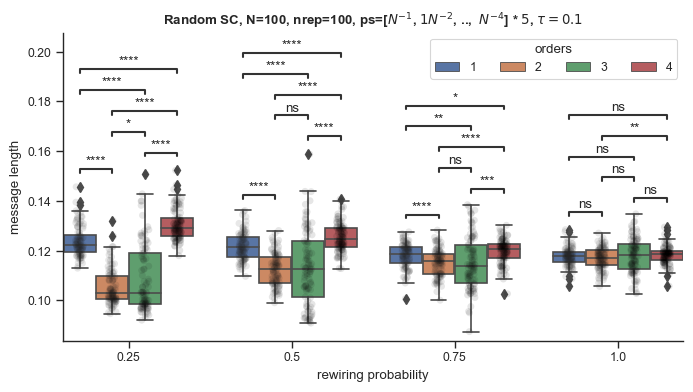

In [25]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $5$, $\tau=0.1$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_tau_01_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [26]:
tau_c = 0.2

Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [27]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:6.310e-01 t=-4.813e-01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:2.659e-02 t=2.237e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.325e-01 t=1.510e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:6.109e-03 t=-2.777e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.715e-08 t=5.881e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:9.137e-07 t=-5.085e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:5.278e-50 t=2.021e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:2.574e-46 t=-1.952e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.364e-22 t=1.111e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:1.148e-17 t=-9.62

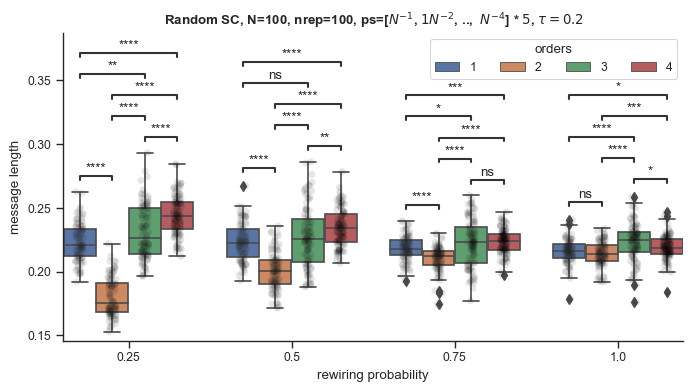

In [28]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $5$, $\tau=0.2$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_tau_02_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [29]:
tau_c = 2

Ds_H = np.zeros((100, 4, 4))
lZs_H = np.zeros((100, 4, 4))

for rep in range(100):
    if (rep + 1) % 100 == 0:
        print(rep + 1)
    for i, p in enumerate(np.linspace(0.25, 1, 4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep, i], lZs_H[rep, i], _ = compute_information(
            H, tau_c, rescale_per_node=False
        )

100


In [30]:
message_lengths = dict()


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, p in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[p] = pad_arr_list(Ds_H[:, i, :] + lZs_H[:, i, :])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.056e-02 t=-2.179e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:2.245e-03 t=-3.096e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:2.306e-07 t=5.413e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:4.721e-02 t=-1.997e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:7.989e-02 t=1.762e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.391e-01 t=-1.485e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:9.559e-35 t=-1.513e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.935e-60 t=-2.467e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:5.008e-06 t=-4.710e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:7.530e-75 t=-3

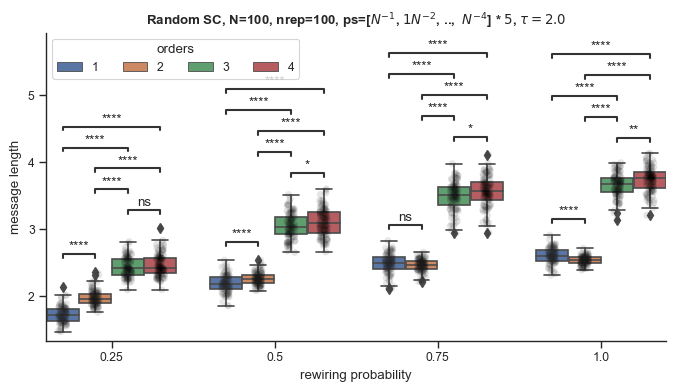

In [31]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $5$, $\tau=2.0$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_tau_2_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

## Changing $\tau_c$ for each realization

### density = 5

In [39]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [40]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [41]:
def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.708e-01 t=-8.970e-01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:9.892e-01 t=1.356e-02
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:9.378e-01 t=7.808e-02
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:6.325e-08 t=-5.626e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:7.060e-01 t=3.777e-01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.432e-32 t=-1.445e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:2.775e-06 t=4.829e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.154e-17 t=9.427e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:7.977e-02 t=1.761e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:3.572e-04 t=3.633e

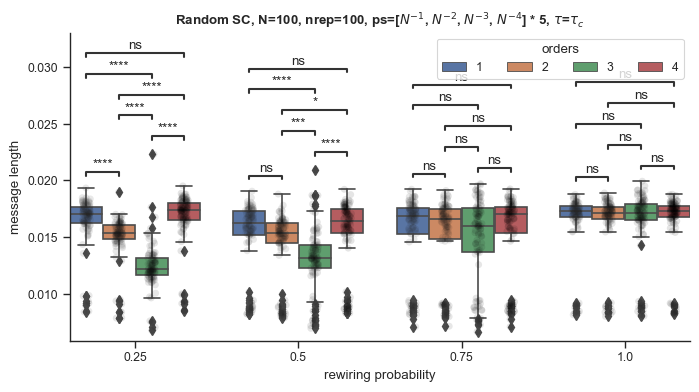

In [42]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_1_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [43]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [44]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 10 * tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [45]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:5.712e-01 t=-5.672e-01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:5.446e-01 t=6.069e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:7.020e-01 t=3.832e-01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:2.217e-02 t=-2.306e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.041e-01 t=1.274e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:7.819e-05 t=-4.037e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:7.161e-15 t=8.437e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:5.173e-09 t=-6.150e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.350e-04 t=3.894e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:7.904e-03 t=-2.68

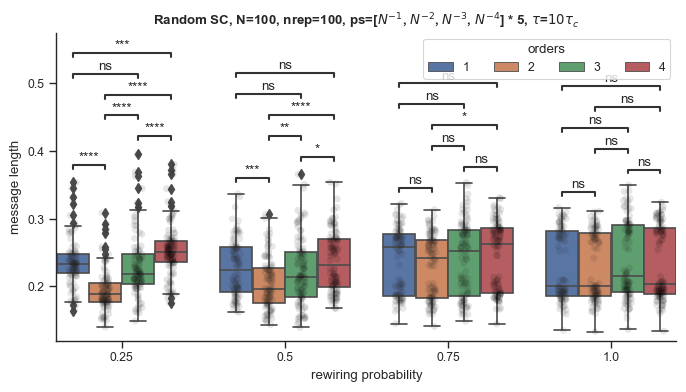

In [47]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$10\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_10_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [16]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [17]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 30 * tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [18]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:6.736e-01 t=-4.218e-01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:6.543e-01 t=-4.484e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.983e-01 t=1.291e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:6.125e-01 t=-5.073e-01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.680e-02 t=2.102e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:5.652e-01 t=-5.761e-01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.800e-05 t=4.397e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:8.439e-16 t=-8.781e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.049e-02 t=2.584e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:3.314e-06 t=-4.7

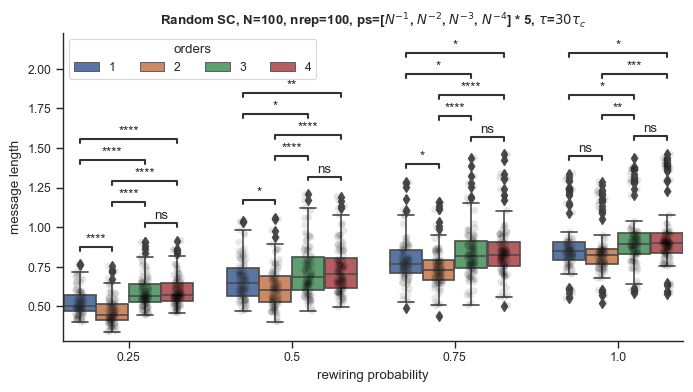

In [19]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$30\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_30_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [48]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [49]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(
            H, 100 * tau_c, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [50]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:2.176e-02 t=-2.313e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:6.681e-03 t=-2.742e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:5.312e-18 t=-1.044e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.401e-02 t=-2.135e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.833e-13 t=-8.357e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.125e-01 t=-1.594e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:5.711e-13 t=-7.732e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.320e-22 t=-1.121e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.246e-06 t=-5.033e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:8.522e-51 t=

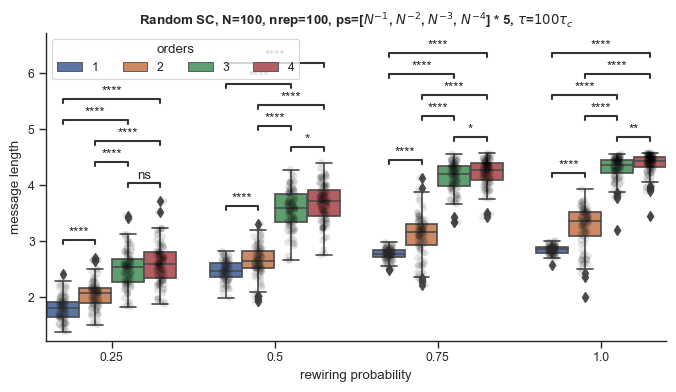

In [51]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$100\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_100_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

### density = 50

In [52]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [53]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [54]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.340e-06 t=-4.987e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:3.478e-03 t=-2.958e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.148e-01 t=1.584e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:7.327e-26 t=-1.232e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.217e-02 t=2.158e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:6.907e-48 t=-2.027e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:9.989e-10 t=6.422e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:9.144e-29 t=1.326e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.184e-05 t=4.259e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:4.755e-11 t=6.976

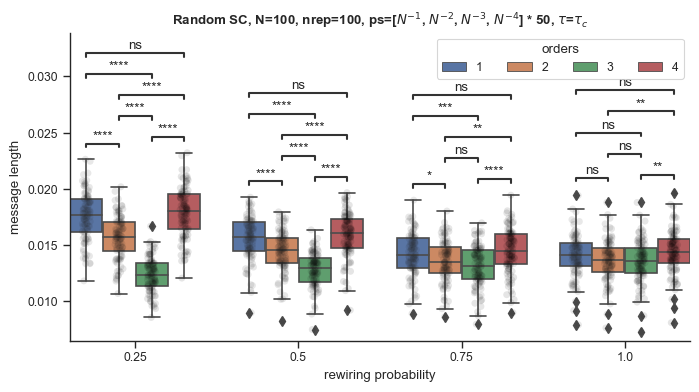

In [55]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_1_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [56]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [57]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 10 * tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [58]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.555e-40 t=-1.880e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:9.031e-42 t=-1.965e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:6.078e-23 t=1.150e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:8.957e-39 t=-1.771e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:4.492e-22 t=1.117e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:4.903e-51 t=-2.240e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.009e-28 t=1.344e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.798e-12 t=7.526e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.010e-21 t=1.086e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:5.088e-06 t=4.690

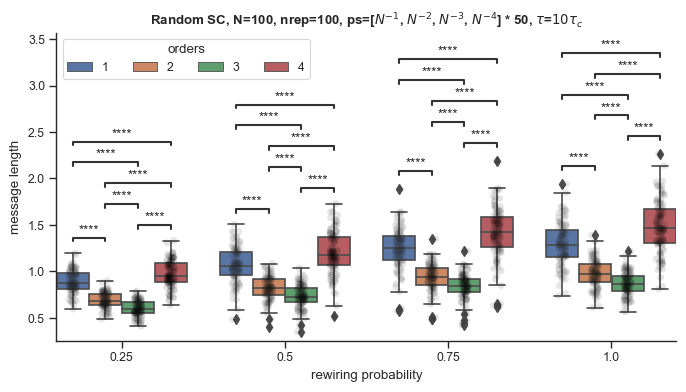

In [59]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$10\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_10_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [60]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [61]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(
            H, 100 * tau_c, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [62]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.229e-02 t=-2.165e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:8.555e-02 t=-1.734e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:9.129e-89 t=-7.450e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.416e-02 t=-2.137e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.403e-90 t=-7.733e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.001e-03 t=-3.010e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.427e-108 t=-1.184e+02
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:3.218e-21 t=-1.209e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.773e-99 t=-9.512e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:1.842e-14 t

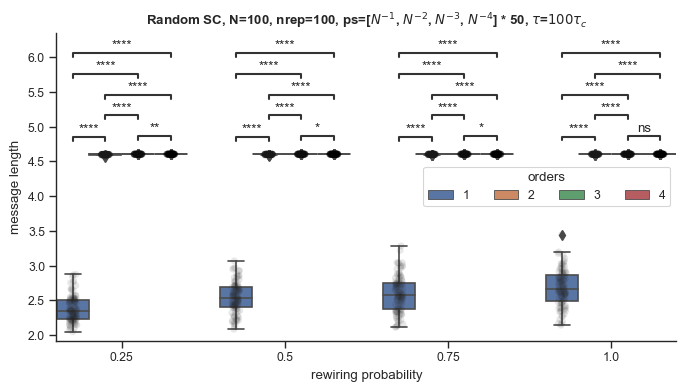

In [63]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$100\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_100_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [64]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [65]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 30 * tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [67]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.111e-19 t=-1.041e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:2.145e-24 t=-1.269e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:5.927e-105 t=7.550e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.098e-19 t=-1.036e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.374e-106 t=7.480e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.367e-22 t=-1.107e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:2.087e-128 t=6.036e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:1.752e-79 t=-4.558e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.428e-130 t=7.460e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:8.575e-91 t=

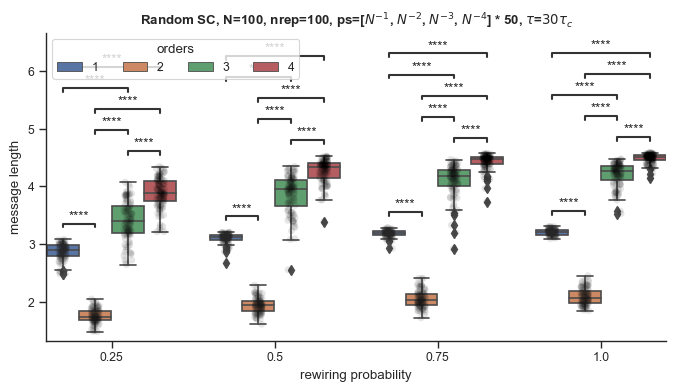

In [68]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$30\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_30_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

## density = 100

In [69]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [70]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [71]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:2.387e-21 t=-1.073e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:2.145e-12 t=-7.505e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:3.700e-04 t=3.623e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:5.336e-43 t=-1.820e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.446e-06 t=4.779e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.481e-64 t=-2.753e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.864e-18 t=9.720e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:5.245e-38 t=1.647e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.515e-11 t=7.020e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:5.864e-16 t=8.846

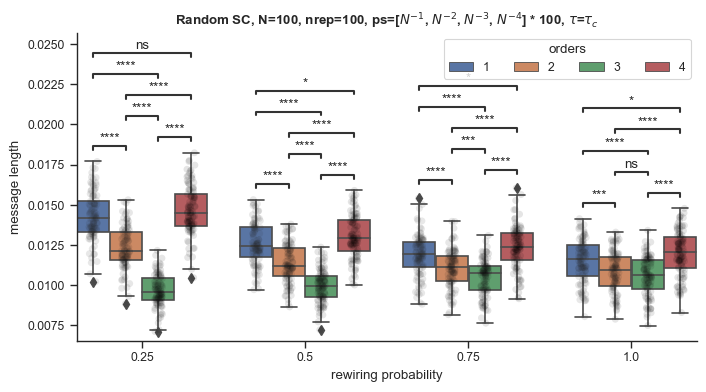

In [72]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_1_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [4]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [5]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 10 * tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [6]:
def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list


for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:6.765e-68 t=-3.323e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:5.317e-75 t=-3.741e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.538e-50 t=2.208e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.929e-66 t=-3.233e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:4.715e-44 t=1.936e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.460e-67 t=-3.243e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.781e-43 t=1.906e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:6.845e-25 t=1.187e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:5.886e-43 t=1.892e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:4.054e-24 t=1.162

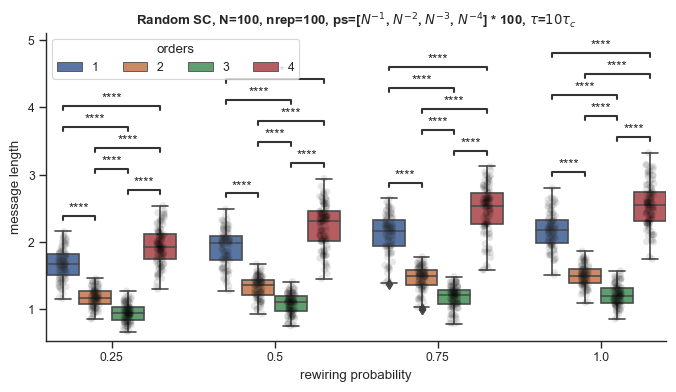

In [7]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$10\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_10_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [8]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [9]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(H, 30 * tau_c, rescale_per_node=False)

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [10]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:2.159e-33 t=-1.807e+01
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:1.464e-21 t=-1.223e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:8.266e-05 t=-4.075e+00
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.112e-32 t=-1.766e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.615e-04 t=-3.895e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.736e-34 t=-1.819e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.601e-37 t=1.846e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:3.018e-102 t=-8.302e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:2.237e-11 t=7.369e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:3.165e-88 t=-

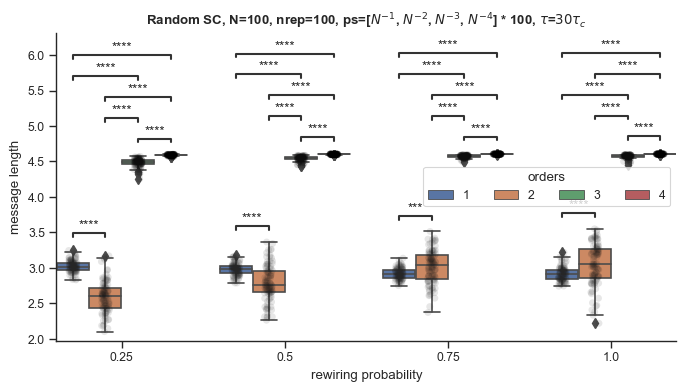

In [11]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$30\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_30_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [12]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0.25, 1, 4):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        H = shuffle_hyperedges(S=H0, order=1, p=p)
        H = shuffle_hyperedges(S=H, order=2, p=p)
        H = shuffle_hyperedges(S=H, order=3, p=p)
        H = shuffle_hyperedges(S=H, order=4, p=p)
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100


In [13]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H, orders = compute_information(
            H, 100 * tau_c, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [14]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:8.314e-02 t=-1.750e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:1.505e-05 t=-4.553e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.517e-74 t=-5.308e+01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.021e-01 t=-1.037e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:2.458e-74 t=-5.282e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.941e-16 t=-9.867e+00
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:6.470e-87 t=-7.132e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:6.343e-24 t=-1.338e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:4.662e-77 t=-5.639e+01
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:2.692e-09 t=

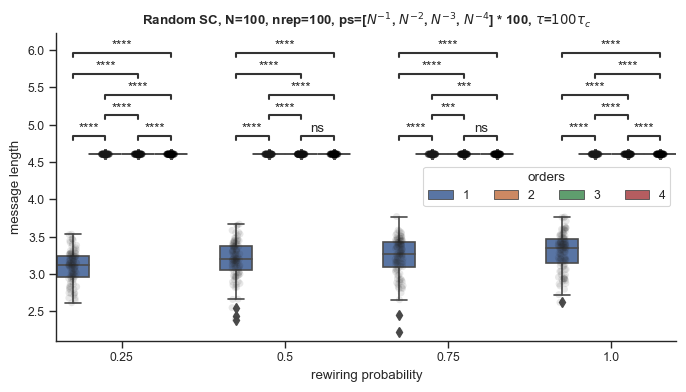

In [15]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$100\tau_c$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_100_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")